In [33]:
# """
# Segmentation Training Script (ULTIMATE: DINOv2 Large + Heavy Head + Rotation)
# Designed for Maximum Accuracy (IoU) without VRAM constraints.
# """

# import torch
# from torch.utils.data import Dataset, DataLoader
# import numpy as np
# from torch import nn
# import torch.nn.functional as F
# import matplotlib.pyplot as plt
# import torch.optim as optim
# import torchvision.transforms as transforms
# import torchvision.transforms.functional as TF
# from PIL import Image
# import cv2
# import os
# import random
# from tqdm.notebook import tqdm
# from torch.cuda.amp import autocast, GradScaler

# # Set matplotlib to non-interactive backend
# plt.switch_backend('Agg')


# # ============================================================================
# # 1. Heavy Weighted Loss (Focal + Dice)
# # ============================================================================

# class HeavyWeightedLoss(nn.Module):
#     def __init__(self, num_classes, device):
#         super().__init__()
#         self.num_classes = num_classes
        
#         # Aggressive weighting for rare classes (Rocks/Logs)
#         weights = torch.tensor([
#             0.4,  # 0: Background
#             1.0,  # 1: Trees
#             1.0,  # 2: Lush Bushes
#             0.8,  # 3: Dry Grass
#             1.0,  # 4: Dry Bushes
#             1.5,  # 5: Ground Clutter
#             4.0,  # 6: Logs (Boosted)
#             4.0,  # 7: Rocks (Boosted)
#             1.0,  # 8: Landscape
#             0.4   # 9: Sky
#         ]).float().to(device)
        
#         self.ce = nn.CrossEntropyLoss(weight=weights, reduction='none')
#         self.gamma = 2.0

#     def forward(self, pred, target):
#         # 1. Focal Loss (Focus on hard pixels)
#         ce_loss = self.ce(pred, target)
#         pt = torch.exp(-ce_loss)
#         focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()

#         # 2. Dice Loss (Focus on global shapes)
#         pred_softmax = F.softmax(pred, dim=1)
#         target_one_hot = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2).float()
        
#         dims = (2, 3)
#         intersection = torch.sum(pred_softmax * target_one_hot, dim=dims)
#         union = torch.sum(pred_softmax + target_one_hot, dim=dims)
        
#         dice_score = (2. * intersection + 1.0) / (union + 1.0)
#         dice_loss = 1.0 - torch.mean(dice_score)

#         # 40% Focal, 60% Dice (Prioritize IoU overlap)
#         return 0.4 * focal_loss + 0.6 * dice_loss


# # ============================================================================
# # Utility
# # ============================================================================

# value_map = {
#     0: 0, 100: 1, 200: 2, 300: 3, 500: 4, 
#     550: 5, 700: 6, 800: 7, 7100: 8, 10000: 9
# }
# n_classes = len(value_map)

# def convert_mask(mask):
#     arr = np.array(mask)
#     new_arr = np.zeros_like(arr, dtype=np.uint8)
#     for raw_value, new_value in value_map.items():
#         new_arr[arr == raw_value] = new_value
#     return Image.fromarray(new_arr)


# # ============================================================================
# # Dataset (Scale Jitter + Rotation)
# # ============================================================================

# class MaskDataset(Dataset):
#     def __init__(self, data_dir, height, width, is_train=True):
#         self.image_dir = os.path.join(data_dir, 'Color_Images')
#         self.masks_dir = os.path.join(data_dir, 'Segmentation')
#         self.height = height
#         self.width = width
#         self.is_train = is_train
#         self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
#                                               std=[0.229, 0.224, 0.225])
        
#         self.color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.1)

#         if not os.path.exists(self.image_dir):
#             raise FileNotFoundError(f"Could not find image directory: {self.image_dir}")
#         self.data_ids = os.listdir(self.image_dir)

#     def __len__(self):
#         return len(self.data_ids)

#     def __getitem__(self, idx):
#         data_id = self.data_ids[idx]
#         img_path = os.path.join(self.image_dir, data_id)
#         mask_path = os.path.join(self.masks_dir, data_id)

#         image = Image.open(img_path).convert("RGB")
#         mask = Image.open(mask_path)
#         mask = convert_mask(mask)

#         # -----------------------------------------------------------
#         # AGGRESSIVE AUGMENTATION
#         # -----------------------------------------------------------
#         if self.is_train:
#             # 1. Random Rotation (New!)
#             # Rotate both image and mask identical amounts
#             if random.random() > 0.5:
#                 angle = random.uniform(-15, 15)
#                 image = TF.rotate(image, angle)
#                 mask = TF.rotate(mask, angle, interpolation=transforms.InterpolationMode.NEAREST)

#             # 2. Scale Jitter (0.6x to 1.4x)
#             scale = random.uniform(0.6, 1.4)
#             new_h, new_w = int(self.height * scale), int(self.width * scale)
            
#             image = TF.resize(image, (new_h, new_w), interpolation=transforms.InterpolationMode.BILINEAR)
#             mask = TF.resize(mask, (new_h, new_w), interpolation=transforms.InterpolationMode.NEAREST)
            
#             # 3. Crop or Pad
#             if scale >= 1.0:
#                 i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(self.height, self.width))
#                 image = TF.crop(image, i, j, h, w)
#                 mask = TF.crop(mask, i, j, h, w)
#             else:
#                 pad_h = self.height - new_h
#                 pad_w = self.width - new_w
#                 padding = [pad_w//2, pad_h//2, pad_w - pad_w//2, pad_h - pad_h//2]
#                 image = TF.pad(image, padding, fill=0, padding_mode='constant')
#                 mask = TF.pad(mask, padding, fill=0, padding_mode='constant')

#             # 4. Flip
#             if random.random() > 0.5:
#                 image = TF.hflip(image)
#                 mask = TF.hflip(mask)
            
#             # 5. Color
#             if random.random() > 0.2:
#                 image = self.color_jitter(image)

#         else:
#             image = TF.resize(image, (self.height, self.width), interpolation=transforms.InterpolationMode.BILINEAR)
#             mask = TF.resize(mask, (self.height, self.width), interpolation=transforms.InterpolationMode.NEAREST)

#         image = TF.to_tensor(image)
#         image = self.normalize(image)
#         mask = torch.from_numpy(np.array(mask)).long()

#         return image, mask


# # ============================================================================
# # Model: Heavy Head for DINOv2 Large
# # ============================================================================

# class SegmentationHeadConvNeXt(nn.Module):
#     def __init__(self, in_channels, out_channels, tokenW, tokenH):
#         super().__init__()
#         self.H, self.W = tokenH, tokenW
        
#         # Increased capacity (512 channels) to handle Large Backbone features
#         self.stem = nn.Sequential(
#             nn.Conv2d(in_channels, 512, 3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.GELU()
#         )
#         self.block1 = nn.Sequential(
#             nn.Conv2d(512, 512, 3, padding=1, groups=512), # Depthwise
#             nn.GELU(),
#             nn.Conv2d(512, 512, 1), # Pointwise
#             nn.BatchNorm2d(512),
#             nn.GELU()
#         )
#         self.block2 = nn.Sequential(
#             nn.Conv2d(512, 256, 3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.GELU(),
#             nn.Dropout(0.2)
#         )
#         self.classifier = nn.Conv2d(256, out_channels, 1)

#     def forward(self, x):
#         B, N, C = x.shape
#         x = x.reshape(B, self.H, self.W, C).permute(0, 3, 1, 2)
#         x = self.stem(x)
#         x = self.block1(x)
#         x = self.block2(x)
#         return self.classifier(x)

# def evaluate(model, backbone, loader, device, n_classes, loss_fct):
#     model.eval()
#     ious, losses = [], []
    
#     # Validation loop
#     with torch.no_grad():
#         with autocast():
#             for imgs, labels in loader:
#                 imgs, labels = imgs.to(device), labels.to(device)
#                 if len(labels.shape) == 4: labels = labels.squeeze(1)
                
#                 output = backbone.forward_features(imgs)["x_norm_patchtokens"]
#                 logits = model(output)
#                 outputs = F.interpolate(logits, size=imgs.shape[2:], mode="bilinear", align_corners=False)
                
#                 losses.append(loss_fct(outputs, labels).item())
                
#                 # IOU Calculation
#                 pred = torch.argmax(outputs, dim=1).view(-1)
#                 t = labels.view(-1)
#                 for cls in range(n_classes):
#                     if cls == 255: continue
#                     p, target_cls = (pred == cls), (t == cls)
#                     inter = (p & target_cls).sum().float()
#                     union = (p | target_cls).sum().float()
#                     if union > 0: ious.append((inter / union).cpu().numpy())
                    
#     model.train()
#     # Handle edge case where ious is empty
#     mean_iou = np.nanmean(ious) if ious else 0.0
#     return np.mean(losses), mean_iou


# # ============================================================================
# # Main Training Loop
# # ============================================================================

# def find_train_path(start_path):
#     for root, dirs, files in os.walk(start_path):
#         if 'train' in dirs:
#             pot_train = os.path.join(root, 'train')
#             if 'Color_Images' in os.listdir(pot_train):
#                 return pot_train
#     raise FileNotFoundError("Could not locate dataset.")

# def main():
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     torch.backends.cudnn.benchmark = True
#     print(f"Device: {device}")

#     # ============================================================
#     # CONFIGURATION FOR MAX PERFORMANCE
#     # ============================================================
#     batch_size = 16        # Low batch size for Large model (VRAM intensive)
#     w, h = 952, 532 
#     lr = 3e-4             # Slower learning rate for Large backbone
#     n_epochs = 30         # More epochs for better convergence
#     num_workers = 4 
#     # ============================================================

#     try:
#         data_dir = find_train_path('/kaggle/input')
#         val_dir = os.path.join(os.path.dirname(data_dir), 'val')
#     except:
#         print("Error locating dataset.")
#         return

#     # Data
#     trainset = MaskDataset(data_dir, h, w, is_train=True)
#     train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, 
#                               num_workers=num_workers, pin_memory=True, persistent_workers=True)
    
#     if os.path.exists(val_dir):
#         valset = MaskDataset(val_dir, h, w, is_train=False)
#         val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, 
#                                 num_workers=num_workers, pin_memory=True, persistent_workers=True)
#     else:
#         val_loader = DataLoader(trainset, batch_size=batch_size, shuffle=False)

#     print(f"Model: DINOv2 LARGE (vitl14) | Head: 512-dim | Aug: +Rotation")

#     # LOAD DINOv2 LARGE (1024 embedding dim)
#     print("Loading DINOv2 Large (vitl14)...")
#     backbone = torch.hub.load("facebookresearch/dinov2", "dinov2_vitl14").to(device).eval()
#     n_embed = 1024 # Dimension for Large model
    
#     model = SegmentationHeadConvNeXt(n_embed, n_classes, w//14, h//14).to(device)
    
#     optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.02)
#     scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=n_epochs)
    
#     loss_fct = HeavyWeightedLoss(n_classes, device).to(device)
#     scaler = GradScaler()

#     history = {'train_loss': [], 'val_loss': [], 'val_iou': []}

#     print(f"\nStarting Training for {n_epochs} epochs...")
    
#     for epoch in range(n_epochs):
#         model.train()
#         train_losses = []
        
#         pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}", leave=True, mininterval=2.0)
        
#         for imgs, labels in pbar:
#             imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
#             if len(labels.shape) == 4: labels = labels.squeeze(1)

#             with autocast():
#                 with torch.no_grad():
#                     features = backbone.forward_features(imgs)["x_norm_patchtokens"]
#                 logits = model(features)
#                 outputs = F.interpolate(logits, size=imgs.shape[2:], mode="bilinear", align_corners=False)
#                 loss = loss_fct(outputs, labels)
            
#             optimizer.zero_grad(set_to_none=True)
#             scaler.scale(loss).backward()
#             scaler.unscale_(optimizer)
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Tighter clip
#             scaler.step(optimizer)
#             scaler.update()
#             scheduler.step()

#             train_losses.append(loss.item())
#             pbar.set_postfix(loss=f"{loss.item():.4f}")

#         # Validation
#         val_loss, val_iou = evaluate(model, backbone, val_loader, device, n_classes, loss_fct)
        
#         history['train_loss'].append(np.mean(train_losses))
#         history['val_loss'].append(val_loss)
#         history['val_iou'].append(val_iou)
        
#         print(f"Epoch {epoch+1} Summary: Train Loss={np.mean(train_losses):.4f} | Val Loss={val_loss:.4f} | Val IoU={val_iou:.4f}")

#     # Save
#     os.makedirs('/kaggle/working/train_stats', exist_ok=True)
#     torch.save(model.state_dict(), '/kaggle/working/segmentation_head.pth')
    
#     # Plot
#     plt.figure(figsize=(10, 4))
#     plt.subplot(1,2,1)
#     plt.plot(history['train_loss'], label='Train')
#     plt.plot(history['val_loss'], label='Val')
#     plt.title('Loss')
#     plt.legend()
#     plt.subplot(1,2,2)
#     plt.plot(history['val_iou'], label='Val IoU')
#     plt.title('IoU')
#     plt.savefig('/kaggle/working/train_stats/curves.png')
#     print("Training Complete. Model saved.")

# if __name__ == "__main__":
#     main()

In [34]:
# """
# Segmentation Testing Script (FIXED)
# Matches Training: DINOv2 Large + Heavy Head (Depthwise Sep Conv)
# """

# import torch
# from torch.utils.data import Dataset, DataLoader
# import numpy as np
# from torch import nn
# import torch.nn.functional as F
# import matplotlib.pyplot as plt
# import torchvision.transforms as transforms
# import torchvision.transforms.functional as TF
# from PIL import Image
# import cv2
# import os
# import shutil
# from tqdm.notebook import tqdm

# # Allow plots to show in the notebook
# %matplotlib inline 

# # ============================================================================
# # Config
# # ============================================================================

# CLASS_NAMES = [
#     'Background', 'Trees', 'Lush Bushes', 'Dry Grass', 'Dry Bushes',
#     'Ground Clutter', 'Logs', 'Rocks', 'Landscape', 'Sky'
# ]

# # Consistent Color Palette
# COLOR_PALETTE = np.array([
#     [0, 0, 0],       # Background - black
#     [34, 139, 34],   # Trees - forest green
#     [0, 255, 0],     # Lush Bushes - lime
#     [210, 180, 140], # Dry Grass - tan
#     [139, 90, 43],   # Dry Bushes - brown
#     [128, 128, 0],   # Ground Clutter - olive
#     [139, 69, 19],   # Logs - saddle brown
#     [128, 128, 128], # Rocks - gray
#     [160, 82, 45],   # Landscape - sienna
#     [135, 206, 235], # Sky - sky blue
# ], dtype=np.uint8)

# VALUE_MAP = {
#     0: 0, 100: 1, 200: 2, 300: 3, 500: 4, 
#     550: 5, 700: 6, 800: 7, 7100: 8, 10000: 9
# }

# N_CLASSES = len(VALUE_MAP)


# # ============================================================================
# # Utilities
# # ============================================================================

# def convert_mask(mask):
#     """Convert raw mask values to class IDs."""
#     arr = np.array(mask)
#     new_arr = np.zeros_like(arr, dtype=np.uint8)
#     for raw_value, new_value in VALUE_MAP.items():
#         new_arr[arr == raw_value] = new_value
#     return Image.fromarray(new_arr)

# def mask_to_color(mask):
#     """Convert a class mask (H, W) to a colored RGB image (H, W, 3)."""
#     h, w = mask.shape
#     color_mask = np.zeros((h, w, 3), dtype=np.uint8)
#     for class_id in range(N_CLASSES):
#         color_mask[mask == class_id] = COLOR_PALETTE[class_id]
#     return color_mask

# def show_inline(img_tensor, pred_mask, gt_mask=None):
#     """Show prediction inline in notebook."""
#     # Denormalize
#     img = img_tensor.cpu().numpy().transpose(1, 2, 0)
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     img = (img * std + mean)
#     img = np.clip(img, 0, 1)

#     pred_color = mask_to_color(pred_mask.cpu().numpy().astype(np.uint8))
    
#     cols = 3 if gt_mask is not None else 2
#     fig, axes = plt.subplots(1, cols, figsize=(15, 5))
    
#     axes[0].imshow(img)
#     axes[0].set_title('Input Image')
#     axes[0].axis('off')

#     if gt_mask is not None:
#         gt_color = mask_to_color(gt_mask.cpu().numpy().astype(np.uint8))
#         axes[1].imshow(gt_color)
#         axes[1].set_title('Ground Truth')
#         axes[1].axis('off')
#         axes[2].imshow(pred_color)
#         axes[2].set_title('Prediction')
#         axes[2].axis('off')
#     else:
#         axes[1].imshow(pred_color)
#         axes[1].set_title('Prediction')
#         axes[1].axis('off')
        
#     plt.show()

# def save_comparison(img_tensor, pred_mask, output_path, gt_mask=None):
#     """Save side-by-side comparison to file."""
#     img = img_tensor.cpu().numpy().transpose(1, 2, 0)
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     img = (img * std + mean)
#     img = np.clip(img, 0, 1)

#     pred_color = mask_to_color(pred_mask.cpu().numpy().astype(np.uint8))

#     cols = 3 if gt_mask is not None else 2
#     fig, axes = plt.subplots(1, cols, figsize=(15, 5))
    
#     axes[0].imshow(img)
#     axes[0].set_title('Input Image')
#     axes[0].axis('off')

#     if gt_mask is not None:
#         gt_color = mask_to_color(gt_mask.cpu().numpy().astype(np.uint8))
#         axes[1].imshow(gt_color)
#         axes[1].set_title('Ground Truth')
#         axes[1].axis('off')
#         axes[2].imshow(pred_color)
#         axes[2].set_title('Prediction')
#         axes[2].axis('off')
#     else:
#         axes[1].imshow(pred_color)
#         axes[1].set_title('Prediction')
#         axes[1].axis('off')

#     plt.tight_layout()
#     plt.savefig(output_path, bbox_inches='tight')
#     plt.close()


# # ============================================================================
# # Dataset & Model (Must match Pro-Level Training)
# # ============================================================================

# class TestDataset(Dataset):
#     def __init__(self, data_dir, height, width):
#         self.image_dir = os.path.join(data_dir, 'Color_Images')
#         self.masks_dir = os.path.join(data_dir, 'Segmentation')
#         self.height = height
#         self.width = width
#         self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
#                                               std=[0.229, 0.224, 0.225])
        
#         if not os.path.exists(self.image_dir):
#             raise FileNotFoundError(f"Could not find image directory: {self.image_dir}")
#         self.data_ids = os.listdir(self.image_dir)
        
#         # Check if we have masks (Ground Truth) available
#         self.has_masks = os.path.exists(self.masks_dir)

#     def __len__(self):
#         return len(self.data_ids)

#     def __getitem__(self, idx):
#         data_id = self.data_ids[idx]
#         img_path = os.path.join(self.image_dir, data_id)
        
#         image = Image.open(img_path).convert("RGB")
#         image = TF.resize(image, (self.height, self.width), interpolation=transforms.InterpolationMode.BILINEAR)
#         image = TF.to_tensor(image)
#         image = self.normalize(image)

#         mask = torch.zeros((self.height, self.width), dtype=torch.long) # Dummy
#         if self.has_masks:
#             mask_path = os.path.join(self.masks_dir, data_id)
#             if os.path.exists(mask_path):
#                 m = Image.open(mask_path)
#                 m = convert_mask(m)
#                 m = TF.resize(m, (self.height, self.width), interpolation=transforms.InterpolationMode.NEAREST)
#                 mask = torch.from_numpy(np.array(m)).long()

#         return image, mask, data_id

# class SegmentationHeadConvNeXt(nn.Module):
#     def __init__(self, in_channels, out_channels, tokenW, tokenH):
#         super().__init__()
#         self.H, self.W = tokenH, tokenW
        
#         # FIXED: MATCHING TRAINING SCRIPT ARCHITECTURE
#         # Increased capacity (512 channels) to handle Large Backbone features
#         self.stem = nn.Sequential(
#             nn.Conv2d(in_channels, 512, 3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.GELU()
#         )
#         self.block1 = nn.Sequential(
#             nn.Conv2d(512, 512, 3, padding=1, groups=512), # Depthwise
#             nn.GELU(),
#             nn.Conv2d(512, 512, 1), # Pointwise
#             nn.BatchNorm2d(512),
#             nn.GELU()
#         )
#         self.block2 = nn.Sequential(
#             nn.Conv2d(512, 256, 3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.GELU(),
#             nn.Dropout(0.2)
#         )
#         self.classifier = nn.Conv2d(256, out_channels, 1)

#     def forward(self, x):
#         B, N, C = x.shape
#         x = x.reshape(B, self.H, self.W, C).permute(0, 3, 1, 2)
#         x = self.stem(x)
#         x = self.block1(x)
#         x = self.block2(x)
#         return self.classifier(x)


# # ============================================================================
# # Main Test Logic
# # ============================================================================

# def compute_metrics(pred, target, num_classes):
#     """Compute mean IoU for a batch."""
#     pred = torch.argmax(pred, dim=1)
#     ious = []
#     for i in range(pred.shape[0]):
#         p = pred[i].view(-1)
#         t = target[i].view(-1)
#         present_classes = torch.unique(t)
#         cls_ious = []
#         for cls in present_classes:
#             if cls == 255: continue 
#             p_cls = (p == cls)
#             t_cls = (t == cls)
#             inter = (p_cls & t_cls).sum().float()
#             un = (p_cls | t_cls).sum().float()
#             if un > 0: cls_ious.append(inter/un)
        
#         if cls_ious:
#             ious.append(torch.tensor(cls_ious).mean().item())
            
#     return ious

# def find_dataset(start_path):
#     # Try to find 'test', then 'val', then 'train'
#     for root, dirs, files in os.walk(start_path):
#         if 'test' in dirs and os.path.exists(os.path.join(root, 'test', 'Color_Images')):
#             return os.path.join(root, 'test')
    
#     for root, dirs, files in os.walk(start_path):
#         if 'val' in dirs and os.path.exists(os.path.join(root, 'val', 'Color_Images')):
#             return os.path.join(root, 'val')
            
#     for root, dirs, files in os.walk(start_path):
#         if 'train' in dirs and os.path.exists(os.path.join(root, 'train', 'Color_Images')):
#             return os.path.join(root, 'train')
            
#     raise FileNotFoundError("Could not locate dataset.")

# def main():
#     print("="*50, flush=True)
#     print("STARTING TESTING / EVALUATION", flush=True)
#     print("="*50, flush=True)

#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f"Device: {device}", flush=True)

#     # 1. Paths
#     try:
#         data_dir = find_dataset('/kaggle/input')
#         print(f"Testing on dataset: {data_dir}", flush=True)
#     except:
#         print("Dataset not found.", flush=True)
#         return

#     model_path = '/kaggle/working/segmentation_head.pth'
#     if not os.path.exists(model_path):
#         print(f"Model not found at {model_path}", flush=True)
#         return

#     output_dir = '/kaggle/working/test_results'
#     if os.path.exists(output_dir): shutil.rmtree(output_dir)
#     os.makedirs(os.path.join(output_dir, 'comparisons'), exist_ok=True)
#     os.makedirs(os.path.join(output_dir, 'masks'), exist_ok=True)

#     # 2. Config (Must match Training)
#     w, h = 952, 532
#     n_embed = 1024 # FIXED: DINOv2 Large has 1024 embedding dim
    
#     # 3. Load Model
#     print("Loading DINOv2 Large (vitl14)...", flush=True)
#     backbone = torch.hub.load("facebookresearch/dinov2", "dinov2_vitl14").to(device).eval()
    
#     model = SegmentationHeadConvNeXt(n_embed, N_CLASSES, w//14, h//14)
#     model.load_state_dict(torch.load(model_path, map_location=device))
#     model.to(device).eval()
    
#     # 4. Data
#     testset = TestDataset(data_dir, h, w)
#     test_loader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
#     print(f"Loaded {len(testset)} test images.", flush=True)

#     # 5. Inference
#     all_ious = []
    
#     print("Running inference...", flush=True)
#     with torch.no_grad():
#         for i, (imgs, labels, ids) in enumerate(tqdm(test_loader)):
#             imgs = imgs.to(device)
#             labels = labels.to(device)
#             if len(labels.shape) == 4: labels = labels.squeeze(1)
            
#             # Forward
#             features = backbone.forward_features(imgs)["x_norm_patchtokens"]
#             logits = model(features)
#             outputs = F.interpolate(logits, size=imgs.shape[2:], mode="bilinear", align_corners=False)
#             preds = torch.argmax(outputs, dim=1)
            
#             # Metrics (only if we have masks)
#             if testset.has_masks:
#                 batch_ious = compute_metrics(outputs, labels, N_CLASSES)
#                 all_ious.extend(batch_ious)
            
#             # Save Results
#             for k in range(len(ids)):
#                 # Save Comparison (Input vs Pred vs GT)
#                 save_path = os.path.join(output_dir, 'comparisons', f'{ids[k]}')
#                 gt = labels[k] if testset.has_masks else None
#                 save_comparison(imgs[k], preds[k], save_path, gt_mask=gt)
                
#                 # Save Colored Mask
#                 col_mask = mask_to_color(preds[k].cpu().numpy().astype(np.uint8))
#                 mask_path = os.path.join(output_dir, 'masks', f'{ids[k]}')
#                 cv2.imwrite(mask_path, cv2.cvtColor(col_mask, cv2.COLOR_RGB2BGR))
                
#                 # Show first 3 images inline
#                 if i == 0 and k < 3:
#                     print(f"Sample Result {k+1}:", flush=True)
#                     show_inline(imgs[k], preds[k], gt)

#     # 6. Summary
#     print("\n" + "="*50, flush=True)
#     if all_ious:
#         print(f"TEST MEAN IoU: {np.mean(all_ious):.4f}", flush=True)
#     else:
#         print("Inference Complete (No Ground Truth masks found for metric calculation).", flush=True)
#     print(f"Results saved to: {output_dir}", flush=True)
#     print("="*50, flush=True)
    
#     # Zip
#     shutil.make_archive('/kaggle/working/test_results', 'zip', output_dir)
#     print("Created 'test_results.zip' for download.", flush=True)

# if __name__ == "__main__":
#     main()

In [35]:
# ============================================================================
# IMPORTS
# ============================================================================

# Standard Library
import os
import random
import shutil
from collections import Counter

# Third-party: Core
import numpy as np
import cv2
from PIL import Image

# Third-party: PyTorch
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

# Third-party: Torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

# Third-party: Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Third-party: Metrics
from sklearn.metrics import confusion_matrix

# Matplotlib Configuration
plt.switch_backend('Agg')
%matplotlib inline

print("✓ All imports loaded successfully!")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

✓ All imports loaded successfully!
PyTorch Version: 2.8.0+cu126
CUDA Available: True


In [36]:
# ============================================================================
# GLOBAL CONFIGURATION
# ============================================================================

# Class Names
CLASS_NAMES = [
    'Background', 'Trees', 'Lush Bushes', 'Dry Grass', 'Dry Bushes',
    'Ground Clutter', 'Logs', 'Rocks', 'Landscape', 'Sky'
]

# Color Palette for Visualization
COLOR_PALETTE = np.array([
    [0, 0, 0],       # Background - black
    [34, 139, 34],   # Trees - forest green
    [0, 255, 0],     # Lush Bushes - lime
    [210, 180, 140], # Dry Grass - tan
    [139, 90, 43],   # Dry Bushes - brown
    [128, 128, 0],   # Ground Clutter - olive
    [139, 69, 19],   # Logs - saddle brown
    [128, 128, 128], # Rocks - gray
    [160, 82, 45],   # Landscape - sienna
    [135, 206, 235], # Sky - sky blue
], dtype=np.uint8)

# Value Mapping (Raw Mask → Class ID)
VALUE_MAP = {
    0: 0, 100: 1, 200: 2, 300: 3, 500: 4, 
    550: 5, 700: 6, 800: 7, 7100: 8, 10000: 9
}

N_CLASSES = len(VALUE_MAP)

print(f"Number of classes: {N_CLASSES}")
print(f"Classes: {CLASS_NAMES}")

Number of classes: 10
Classes: ['Background', 'Trees', 'Lush Bushes', 'Dry Grass', 'Dry Bushes', 'Ground Clutter', 'Logs', 'Rocks', 'Landscape', 'Sky']


Device: cuda
Model: DINOv2 LARGE (vitl14) | Head: 512-dim | Aug: +Rotation
Loading DINOv2 Large (vitl14)...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main



Starting Training for 5 epochs...


/tmp/ipykernel_55/4110951084.py:283: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/5:   0%|          | 0/179 [00:00<?, ?it/s]

/tmp/ipykernel_55/4110951084.py:301: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_55/4110951084.py:196: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


✓ New best IoU: 0.5251 - Model saved!


Epoch 2/5:   0%|          | 0/179 [00:00<?, ?it/s]

✓ New best IoU: 0.5521 - Model saved!


Epoch 3/5:   0%|          | 0/179 [00:00<?, ?it/s]

✓ New best IoU: 0.5670 - Model saved!


Epoch 4/5:   0%|          | 0/179 [00:00<?, ?it/s]

✓ New best IoU: 0.5700 - Model saved!


Epoch 5/5:   0%|          | 0/179 [00:00<?, ?it/s]

✓ New best IoU: 0.5710 - Model saved!
Training Complete. Best IoU: 0.5710


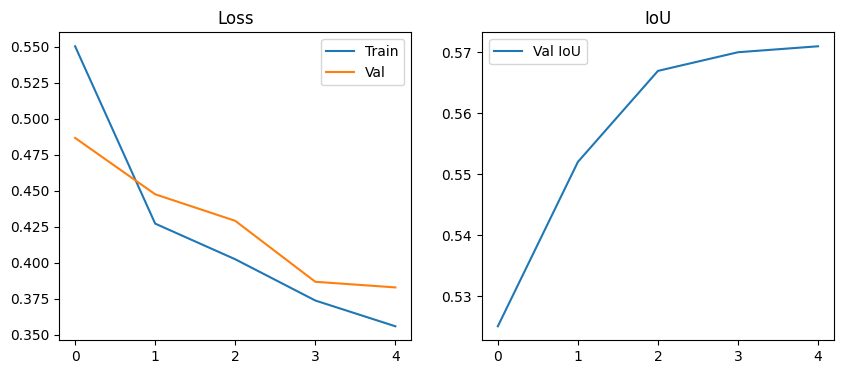

In [37]:
"""
Segmentation Training Script (ULTIMATE: DINOv2 Large + Heavy Head + Rotation)
Designed for Maximum Accuracy (IoU) without VRAM constraints.
"""

# ============================================================================
# 1. Heavy Weighted Loss (Focal + Dice)
# ============================================================================

class HeavyWeightedLoss(nn.Module):
    def __init__(self, num_classes, device):
        super().__init__()
        self.num_classes = num_classes
        
        # Aggressive weighting for rare classes (Rocks/Logs)
        weights = torch.tensor([
            0.4,  # 0: Background
            1.0,  # 1: Trees
            1.0,  # 2: Lush Bushes
            0.8,  # 3: Dry Grass
            1.0,  # 4: Dry Bushes
            1.5,  # 5: Ground Clutter
            4.0,  # 6: Logs (Boosted)
            4.0,  # 7: Rocks (Boosted)
            1.0,  # 8: Landscape
            0.4   # 9: Sky
        ]).float().to(device)
        
        self.ce = nn.CrossEntropyLoss(weight=weights, reduction='none')
        self.gamma = 2.0

    def forward(self, pred, target):
        # 1. Focal Loss (Focus on hard pixels)
        ce_loss = self.ce(pred, target)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()

        # 2. Dice Loss (Focus on global shapes)
        pred_softmax = F.softmax(pred, dim=1)
        target_one_hot = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2).float()
        
        dims = (2, 3)
        intersection = torch.sum(pred_softmax * target_one_hot, dim=dims)
        union = torch.sum(pred_softmax + target_one_hot, dim=dims)
        
        dice_score = (2. * intersection + 1.0) / (union + 1.0)
        dice_loss = 1.0 - torch.mean(dice_score)

        # 40% Focal, 60% Dice (Prioritize IoU overlap)
        return 0.4 * focal_loss + 0.6 * dice_loss


# ============================================================================
# 2. Utility Functions
# ============================================================================

value_map = VALUE_MAP
n_classes = N_CLASSES

def convert_mask(mask):
    """Convert raw mask values to class IDs."""
    arr = np.array(mask)
    new_arr = np.zeros_like(arr, dtype=np.uint8)
    for raw_value, new_value in value_map.items():
        new_arr[arr == raw_value] = new_value
    return Image.fromarray(new_arr)


# ============================================================================
# 3. Dataset (Scale Jitter + Rotation)
# ============================================================================

class MaskDataset(Dataset):
    def __init__(self, data_dir, height, width, is_train=True):
        self.image_dir = os.path.join(data_dir, 'Color_Images')
        self.masks_dir = os.path.join(data_dir, 'Segmentation')
        self.height = height
        self.width = width
        self.is_train = is_train
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                              std=[0.229, 0.224, 0.225])
        
        self.color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.1)

        if not os.path.exists(self.image_dir):
            raise FileNotFoundError(f"Could not find image directory: {self.image_dir}")
        self.data_ids = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.data_ids)

    def __getitem__(self, idx):
        data_id = self.data_ids[idx]
        img_path = os.path.join(self.image_dir, data_id)
        mask_path = os.path.join(self.masks_dir, data_id)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = convert_mask(mask)

        # AGGRESSIVE AUGMENTATION
        if self.is_train:
            # 1. Random Rotation
            if random.random() > 0.5:
                angle = random.uniform(-15, 15)
                image = TF.rotate(image, angle)
                mask = TF.rotate(mask, angle, interpolation=transforms.InterpolationMode.NEAREST)

            # 2. Scale Jitter (0.6x to 1.4x)
            scale = random.uniform(0.6, 1.4)
            new_h, new_w = int(self.height * scale), int(self.width * scale)
            
            image = TF.resize(image, (new_h, new_w), interpolation=transforms.InterpolationMode.BILINEAR)
            mask = TF.resize(mask, (new_h, new_w), interpolation=transforms.InterpolationMode.NEAREST)
            
            # 3. Crop or Pad
            if scale >= 1.0:
                i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(self.height, self.width))
                image = TF.crop(image, i, j, h, w)
                mask = TF.crop(mask, i, j, h, w)
            else:
                pad_h = self.height - new_h
                pad_w = self.width - new_w
                padding = [pad_w//2, pad_h//2, pad_w - pad_w//2, pad_h - pad_h//2]
                image = TF.pad(image, padding, fill=0, padding_mode='constant')
                mask = TF.pad(mask, padding, fill=0, padding_mode='constant')

            # 4. Flip
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            
            # 5. Color
            if random.random() > 0.2:
                image = self.color_jitter(image)

        else:
            image = TF.resize(image, (self.height, self.width), interpolation=transforms.InterpolationMode.BILINEAR)
            mask = TF.resize(mask, (self.height, self.width), interpolation=transforms.InterpolationMode.NEAREST)

        image = TF.to_tensor(image)
        image = self.normalize(image)
        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask


# ============================================================================
# 4. Model: Heavy Head for DINOv2 Large
# ============================================================================

class SegmentationHeadConvNeXt(nn.Module):
    def __init__(self, in_channels, out_channels, tokenW, tokenH):
        super().__init__()
        self.H, self.W = tokenH, tokenW
        
        # Increased capacity (512 channels) to handle Large Backbone features
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.GELU()
        )
        self.block1 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1, groups=512),  # Depthwise
            nn.GELU(),
            nn.Conv2d(512, 512, 1),  # Pointwise
            nn.BatchNorm2d(512),
            nn.GELU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Conv2d(256, out_channels, 1)

    def forward(self, x):
        B, N, C = x.shape
        x = x.reshape(B, self.H, self.W, C).permute(0, 3, 1, 2)
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        return self.classifier(x)


# ============================================================================
# 5. Evaluation Function
# ============================================================================

def evaluate(model, backbone, loader, device, n_classes, loss_fct):
    model.eval()
    ious, losses = [], []
    
    with torch.no_grad():
        with autocast():
            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.to(device)
                if len(labels.shape) == 4: 
                    labels = labels.squeeze(1)
                
                output = backbone.forward_features(imgs)["x_norm_patchtokens"]
                logits = model(output)
                outputs = F.interpolate(logits, size=imgs.shape[2:], mode="bilinear", align_corners=False)
                
                losses.append(loss_fct(outputs, labels).item())
                
                # IOU Calculation
                pred = torch.argmax(outputs, dim=1).view(-1)
                t = labels.view(-1)
                for cls in range(n_classes):
                    if cls == 255: 
                        continue
                    p, target_cls = (pred == cls), (t == cls)
                    inter = (p & target_cls).sum().float()
                    union = (p | target_cls).sum().float()
                    if union > 0: 
                        ious.append((inter / union).cpu().numpy())
                    
    model.train()
    mean_iou = np.nanmean(ious) if ious else 0.0
    return np.mean(losses), mean_iou


# ============================================================================
# 6. Main Training Loop
# ============================================================================

def find_train_path(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'train' in dirs:
            pot_train = os.path.join(root, 'train')
            if 'Color_Images' in os.listdir(pot_train):
                return pot_train
    raise FileNotFoundError("Could not locate dataset.")


def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.backends.cudnn.benchmark = True
    print(f"Device: {device}")

    # Configuration
    batch_size = 16
    w, h = 952, 532 
    lr = 3e-4
    n_epochs = 5  # Increased from 1 for proper training
    num_workers = 4

    try:
        data_dir = find_train_path('/kaggle/input')
        val_dir = os.path.join(os.path.dirname(data_dir), 'val')
    except:
        print("Error locating dataset.")
        return

    # Data
    trainset = MaskDataset(data_dir, h, w, is_train=True)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                              num_workers=num_workers, pin_memory=True, persistent_workers=True)
    
    if os.path.exists(val_dir):
        valset = MaskDataset(val_dir, h, w, is_train=False)
        val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, 
                                num_workers=num_workers, pin_memory=True, persistent_workers=True)
    else:
        val_loader = DataLoader(trainset, batch_size=batch_size, shuffle=False)

    print(f"Model: DINOv2 LARGE (vitl14) | Head: 512-dim | Aug: +Rotation")

    # Load DINOv2 Large
    print("Loading DINOv2 Large (vitl14)...")
    backbone = torch.hub.load("facebookresearch/dinov2", "dinov2_vitl14").to(device).eval()
    n_embed = 1024
    
    model = SegmentationHeadConvNeXt(n_embed, n_classes, w//14, h//14).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.02)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, 
                                               steps_per_epoch=len(train_loader), epochs=n_epochs)
    
    loss_fct = HeavyWeightedLoss(n_classes, device).to(device)
    scaler = GradScaler()

    history = {'train_loss': [], 'val_loss': [], 'val_iou': []}
    best_iou = 0.0

    print(f"\nStarting Training for {n_epochs} epochs...")
    
    for epoch in range(n_epochs):
        model.train()
        train_losses = []
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}", leave=True, mininterval=2.0)
        
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            if len(labels.shape) == 4: 
                labels = labels.squeeze(1)

            with autocast():
                with torch.no_grad():
                    features = backbone.forward_features(imgs)["x_norm_patchtokens"]
                logits = model(features)
                outputs = F.interpolate(logits, size=imgs.shape[2:], mode="bilinear", align_corners=False)
                loss = loss_fct(outputs, labels)
            
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            train_losses.append(loss.item())
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        # Validation
        val_loss, val_iou = evaluate(model, backbone, val_loader, device, n_classes, loss_fct)
        
        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)
        
        
        # Save best model
        if val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), '/kaggle/working/segmentation_head_best.pth')
            print(f"✓ New best IoU: {best_iou:.4f} - Model saved!")

    # Save
    os.makedirs('/kaggle/working/train_stats', exist_ok=True)
    torch.save(model.state_dict(), '/kaggle/working/segmentation_head.pth')
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['val_iou'], label='Val IoU')
    plt.title('IoU')
    plt.legend()
    plt.savefig('/kaggle/working/train_stats/curves.png')
    print(f"Training Complete. Best IoU: {best_iou:.4f}")
    
    return history


if __name__ == "__main__":
    training_history = main()


In [38]:
# ============================================================================
# Class Distribution Visualization
# ============================================================================

def plot_class_distribution(data_dir, n_samples=100):
    """Visualize class distribution in the dataset."""
    masks_dir = os.path.join(data_dir, 'Segmentation')
    if not os.path.exists(masks_dir):
        print("No segmentation masks found.")
        return
    
    mask_files = os.listdir(masks_dir)[:n_samples]
    class_counts = Counter()
    
    for mask_file in mask_files:
        mask = Image.open(os.path.join(masks_dir, mask_file))
        mask = convert_mask(mask)
        mask_array = np.array(mask)
        
        unique, counts = np.unique(mask_array, return_counts=True)
        for cls, count in zip(unique, counts):
            class_counts[cls] += count
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    classes = sorted(class_counts.keys())
    counts = [class_counts[c] for c in classes]
    
    # Bar chart
    axes[0].bar(classes, counts, color='steelblue', edgecolor='black')
    axes[0].set_xlabel('Class ID')
    axes[0].set_ylabel('Pixel Count')
    axes[0].set_title(f'Class Distribution (sampled {n_samples} images)')
    axes[0].set_xticks(classes)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Pie chart
    axes[1].pie(counts, labels=[CLASS_NAMES[c] for c in classes], 
                autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Class Distribution (Percentage)')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/train_stats/class_distribution.png', dpi=150)
    plt.show()
    print("✓ Class distribution plot saved!")

In [39]:
# ============================================================================
# Training History Visualization
# ============================================================================

def plot_training_history(history_dict):
    """Plot training curves with enhanced visualization."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss curves
    axes[0, 0].plot(history_dict['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history_dict['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # IoU curve
    axes[0, 1].plot(history_dict['val_iou'], label='Val IoU', color='green', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('IoU')
    axes[0, 1].set_title('Validation IoU over Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Best epoch marker
    best_epoch = np.argmax(history_dict['val_iou'])
    best_iou = history_dict['val_iou'][best_epoch]
    axes[0, 1].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5)
    axes[0, 1].text(best_epoch, best_iou, f'Best: {best_iou:.4f}', 
                    fontsize=10, ha='left')
    
    # Loss difference (overfitting indicator)
    loss_diff = np.array(history_dict['val_loss']) - np.array(history_dict['train_loss'])
    axes[1, 0].plot(loss_diff, label='Val - Train Loss', color='orange', linewidth=2)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss Difference')
    axes[1, 0].set_title('Overfitting Indicator (Val - Train Loss)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Summary statistics
    axes[1, 1].axis('off')
    summary_text = f"""
    Training Summary:
    
    Best Val IoU: {max(history_dict['val_iou']):.4f}
    Best Epoch: {best_epoch + 1}
    
    Final Train Loss: {history_dict['train_loss'][-1]:.4f}
    Final Val Loss: {history_dict['val_loss'][-1]:.4f}
    Final Val IoU: {history_dict['val_iou'][-1]:.4f}
    
    Total Epochs: {len(history_dict['train_loss'])}
    """
    axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, 
                     verticalalignment='center', family='monospace',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/train_stats/detailed_curves.png', dpi=150)
    plt.show()
    print("✓ Training plots saved!")

STARTING TESTING / EVALUATION
Device: cuda
Testing on dataset: /kaggle/input/datasets/flameboy01/offroad/Offroad_Segmentation_Training_Dataset/Offroad_Segmentation_Training_Dataset/val
Loading DINOv2 Large (vitl14)...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Loaded 317 test images.
Running inference...


  0%|          | 0/80 [00:00<?, ?it/s]

Sample Result 1:


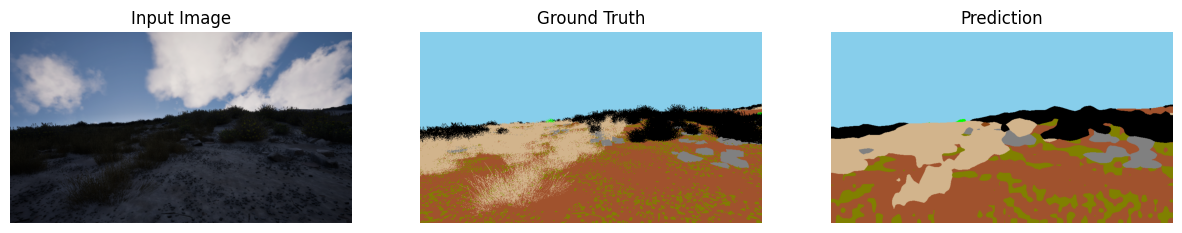

Sample Result 2:


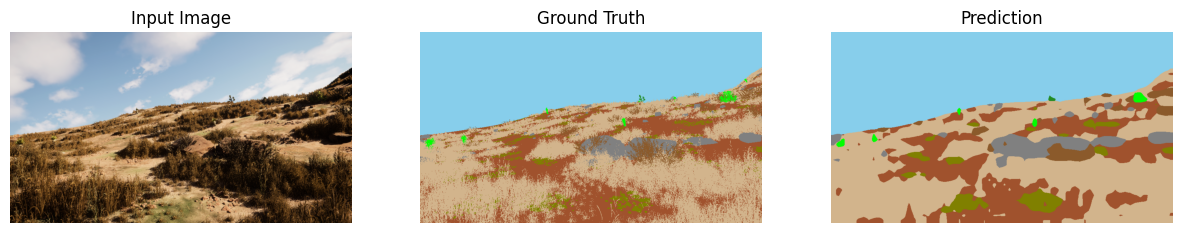

Sample Result 3:


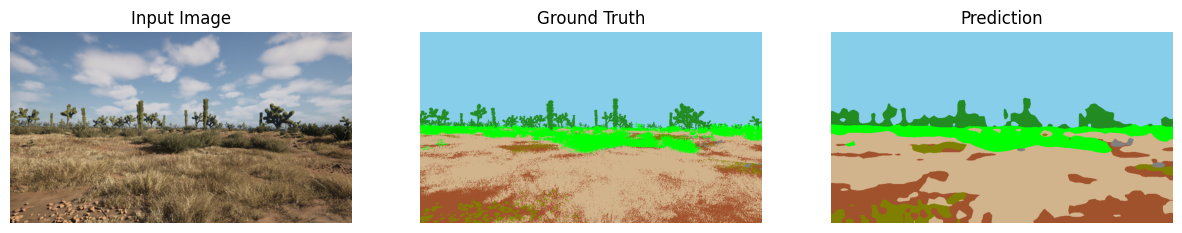


TEST MEAN IoU: 0.5199
Results saved to: /kaggle/working/test_results
Created 'test_results.zip' for download.


In [40]:
"""
Segmentation Testing Script (FIXED)
Matches Training: DINOv2 Large + Heavy Head (Depthwise Sep Conv)
"""

# ============================================================================
# Utility Functions
# ============================================================================

def convert_mask(mask):
    """Convert raw mask values to class IDs."""
    arr = np.array(mask)
    new_arr = np.zeros_like(arr, dtype=np.uint8)
    for raw_value, new_value in VALUE_MAP.items():
        new_arr[arr == raw_value] = new_value
    return Image.fromarray(new_arr)


def mask_to_color(mask):
    """Convert a class mask (H, W) to a colored RGB image (H, W, 3)."""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id in range(N_CLASSES):
        color_mask[mask == class_id] = COLOR_PALETTE[class_id]
    return color_mask


def show_inline(img_tensor, pred_mask, gt_mask=None):
    """Show prediction inline in notebook."""
    # Denormalize
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img * std + mean)
    img = np.clip(img, 0, 1)

    pred_color = mask_to_color(pred_mask.cpu().numpy().astype(np.uint8))
    
    cols = 3 if gt_mask is not None else 2
    fig, axes = plt.subplots(1, cols, figsize=(15, 5))
    
    axes[0].imshow(img)
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    if gt_mask is not None:
        gt_color = mask_to_color(gt_mask.cpu().numpy().astype(np.uint8))
        axes[1].imshow(gt_color)
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')
        axes[2].imshow(pred_color)
        axes[2].set_title('Prediction')
        axes[2].axis('off')
    else:
        axes[1].imshow(pred_color)
        axes[1].set_title('Prediction')
        axes[1].axis('off')
        
    plt.show()


def save_comparison(img_tensor, pred_mask, output_path, gt_mask=None):
    """Save side-by-side comparison to file."""
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img * std + mean)
    img = np.clip(img, 0, 1)

    pred_color = mask_to_color(pred_mask.cpu().numpy().astype(np.uint8))

    cols = 3 if gt_mask is not None else 2
    fig, axes = plt.subplots(1, cols, figsize=(15, 5))
    
    axes[0].imshow(img)
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    if gt_mask is not None:
        gt_color = mask_to_color(gt_mask.cpu().numpy().astype(np.uint8))
        axes[1].imshow(gt_color)
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')
        axes[2].imshow(pred_color)
        axes[2].set_title('Prediction')
        axes[2].axis('off')
    else:
        axes[1].imshow(pred_color)
        axes[1].set_title('Prediction')
        axes[1].axis('off')

    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight')
    plt.close()


# ============================================================================
# Dataset & Model
# ============================================================================

class TestDataset(Dataset):
    def __init__(self, data_dir, height, width):
        self.image_dir = os.path.join(data_dir, 'Color_Images')
        self.masks_dir = os.path.join(data_dir, 'Segmentation')
        self.height = height
        self.width = width
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                              std=[0.229, 0.224, 0.225])
        
        if not os.path.exists(self.image_dir):
            raise FileNotFoundError(f"Could not find image directory: {self.image_dir}")
        self.data_ids = os.listdir(self.image_dir)
        
        # Check if we have masks (Ground Truth) available
        self.has_masks = os.path.exists(self.masks_dir)

    def __len__(self):
        return len(self.data_ids)

    def __getitem__(self, idx):
        data_id = self.data_ids[idx]
        img_path = os.path.join(self.image_dir, data_id)
        
        image = Image.open(img_path).convert("RGB")
        image = TF.resize(image, (self.height, self.width), interpolation=transforms.InterpolationMode.BILINEAR)
        image = TF.to_tensor(image)
        image = self.normalize(image)

        mask = torch.zeros((self.height, self.width), dtype=torch.long)
        if self.has_masks:
            mask_path = os.path.join(self.masks_dir, data_id)
            if os.path.exists(mask_path):
                m = Image.open(mask_path)
                m = convert_mask(m)
                m = TF.resize(m, (self.height, self.width), interpolation=transforms.InterpolationMode.NEAREST)
                mask = torch.from_numpy(np.array(m)).long()

        return image, mask, data_id


class SegmentationHeadConvNeXt(nn.Module):
    def __init__(self, in_channels, out_channels, tokenW, tokenH):
        super().__init__()
        self.H, self.W = tokenH, tokenW
        
        # MATCHING TRAINING SCRIPT ARCHITECTURE
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.GELU()
        )
        self.block1 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1, groups=512),  # Depthwise
            nn.GELU(),
            nn.Conv2d(512, 512, 1),  # Pointwise
            nn.BatchNorm2d(512),
            nn.GELU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Conv2d(256, out_channels, 1)

    def forward(self, x):
        B, N, C = x.shape
        x = x.reshape(B, self.H, self.W, C).permute(0, 3, 1, 2)
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        return self.classifier(x)


# ============================================================================
# Metrics Computation
# ============================================================================

def compute_metrics(pred, target, num_classes):
    """Compute mean IoU for a batch."""
    pred = torch.argmax(pred, dim=1)
    ious = []
    for i in range(pred.shape[0]):
        p = pred[i].view(-1)
        t = target[i].view(-1)
        present_classes = torch.unique(t)
        cls_ious = []
        for cls in present_classes:
            if cls == 255: 
                continue 
            p_cls = (p == cls)
            t_cls = (t == cls)
            inter = (p_cls & t_cls).sum().float()
            un = (p_cls | t_cls).sum().float()
            if un > 0: 
                cls_ious.append(inter/un)
        
        if cls_ious:
            ious.append(torch.tensor(cls_ious).mean().item())
            
    return ious


def find_dataset(start_path):
    """Try to find 'test', then 'val', then 'train'."""
    for root, dirs, files in os.walk(start_path):
        if 'test' in dirs and os.path.exists(os.path.join(root, 'test', 'Color_Images')):
            return os.path.join(root, 'test')
    
    for root, dirs, files in os.walk(start_path):
        if 'val' in dirs and os.path.exists(os.path.join(root, 'val', 'Color_Images')):
            return os.path.join(root, 'val')
            
    for root, dirs, files in os.walk(start_path):
        if 'train' in dirs and os.path.exists(os.path.join(root, 'train', 'Color_Images')):
            return os.path.join(root, 'train')
            
    raise FileNotFoundError("Could not locate dataset.")


# ============================================================================
# Main Testing Logic
# ============================================================================

def main():
    print("="*50, flush=True)
    print("STARTING TESTING / EVALUATION", flush=True)
    print("="*50, flush=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}", flush=True)

    # Paths
    try:
        data_dir = find_dataset('/kaggle/input')
        print(f"Testing on dataset: {data_dir}", flush=True)
    except:
        print("Dataset not found.", flush=True)
        return

    model_path = '/kaggle/working/segmentation_head.pth'
    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}", flush=True)
        return

    output_dir = '/kaggle/working/test_results'
    if os.path.exists(output_dir): 
        shutil.rmtree(output_dir)
    os.makedirs(os.path.join(output_dir, 'comparisons'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'masks'), exist_ok=True)

    # Config
    w, h = 952, 532
    n_embed = 1024
    
    # Load Model
    print("Loading DINOv2 Large (vitl14)...", flush=True)
    backbone = torch.hub.load("facebookresearch/dinov2", "dinov2_vitl14").to(device).eval()
    
    model = SegmentationHeadConvNeXt(n_embed, N_CLASSES, w//14, h//14)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()
    
    # Data
    testset = TestDataset(data_dir, h, w)
    test_loader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
    print(f"Loaded {len(testset)} test images.", flush=True)

    # Inference
    all_ious = []
    all_predictions = []
    all_targets = []
    
    print("Running inference...", flush=True)
    with torch.no_grad():
        for i, (imgs, labels, ids) in enumerate(tqdm(test_loader)):
            imgs = imgs.to(device)
            labels = labels.to(device)
            if len(labels.shape) == 4: 
                labels = labels.squeeze(1)
            
            # Forward
            features = backbone.forward_features(imgs)["x_norm_patchtokens"]
            logits = model(features)
            outputs = F.interpolate(logits, size=imgs.shape[2:], mode="bilinear", align_corners=False)
            preds = torch.argmax(outputs, dim=1)
            
            # Metrics
            if testset.has_masks:
                batch_ious = compute_metrics(outputs, labels, N_CLASSES)
                all_ious.extend(batch_ious)
                
                # Store for detailed analysis
                all_predictions.extend([p.cpu().numpy() for p in preds])
                all_targets.extend([l.cpu().numpy() for l in labels])
            
            # Save Results
            for k in range(len(ids)):
                save_path = os.path.join(output_dir, 'comparisons', f'{ids[k]}')
                gt = labels[k] if testset.has_masks else None
                save_comparison(imgs[k], preds[k], save_path, gt_mask=gt)
                
                col_mask = mask_to_color(preds[k].cpu().numpy().astype(np.uint8))
                mask_path = os.path.join(output_dir, 'masks', f'{ids[k]}')
                cv2.imwrite(mask_path, cv2.cvtColor(col_mask, cv2.COLOR_RGB2BGR))
                
                # Show first 3 images inline
                if i == 0 and k < 3:
                    print(f"Sample Result {k+1}:", flush=True)
                    show_inline(imgs[k], preds[k], gt)

    # Summary
    print("\n" + "="*50, flush=True)
    if all_ious:
        print(f"TEST MEAN IoU: {np.mean(all_ious):.4f}", flush=True)
    else:
        print("Inference Complete (No Ground Truth masks found).", flush=True)
    print(f"Results saved to: {output_dir}", flush=True)
    print("="*50, flush=True)
    
    # Zip
    shutil.make_archive('/kaggle/working/test_results', 'zip', output_dir)
    print("Created 'test_results.zip' for download.", flush=True)
    
    return all_predictions, all_targets


if __name__ == "__main__":
    predictions, targets = main()

In [41]:
# ============================================================================
# Per-Class IoU Analysis
# ============================================================================

def plot_per_class_iou(all_predictions, all_targets, class_names):
    """Calculate and visualize per-class IoU scores."""
    n_classes = len(class_names)
    class_ious = []
    
    for cls in range(n_classes):
        intersection = 0
        union = 0
        
        for pred, target in zip(all_predictions, all_targets):
            pred_mask = (pred == cls)
            target_mask = (target == cls)
            
            intersection += (pred_mask & target_mask).sum()
            union += (pred_mask | target_mask).sum()
        
        if union > 0:
            class_ious.append(intersection / union)
        else:
            class_ious.append(0.0)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = ['red' if iou < 0.5 else 'orange' if iou < 0.7 else 'green' 
              for iou in class_ious]
    
    bars = ax.barh(class_names, class_ious, color=colors, edgecolor='black')
    ax.set_xlabel('IoU Score')
    ax.set_title('Per-Class IoU Performance')
    ax.set_xlim([0, 1])
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, iou) in enumerate(zip(bars, class_ious)):
        ax.text(iou + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{iou:.3f}', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/test_results/per_class_iou.png', dpi=150)
    plt.show()
    
    print(f"\nMean IoU: {np.mean(class_ious):.4f}")
    print("✓ Per-class IoU plot saved!")


# ============================================================================
# Confusion Matrix Visualization
# ============================================================================

def plot_confusion_matrix(all_predictions, all_targets, class_names):
    """Generate and plot confusion matrix."""
    # Flatten all predictions and targets
    all_preds_flat = np.concatenate([p.flatten() for p in all_predictions])
    all_targets_flat = np.concatenate([t.flatten() for t in all_targets])
    
    # Compute confusion matrix
    cm = confusion_matrix(all_targets_flat, all_preds_flat, 
                          labels=range(len(class_names)))
    
    # Normalize by row (true labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, 
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('Confusion Matrix (Counts)')
    
    # Normalized
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn', 
                xticklabels=class_names, yticklabels=class_names, 
                ax=axes[1], vmin=0, vmax=1, cbar_kws={'label': 'Proportion'})
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Confusion Matrix (Normalized)')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/test_results/confusion_matrix.png', dpi=150)
    plt.show()
    print("✓ Confusion matrix saved!")



GENERATING DETAILED ANALYSIS

Creating confusion matrix...


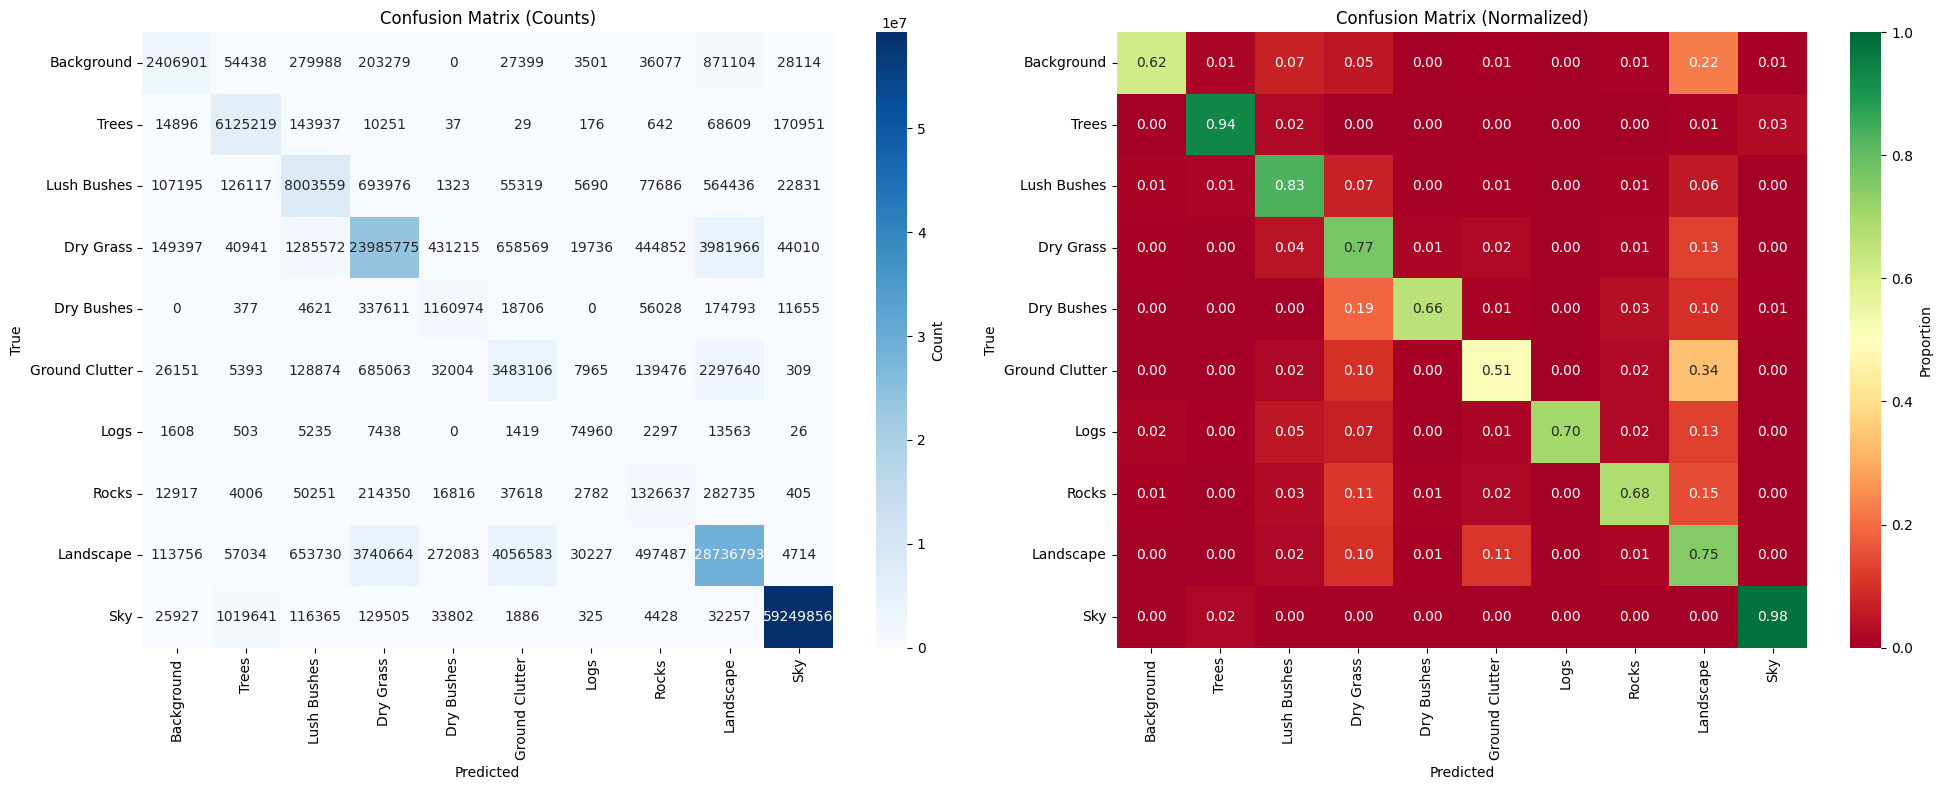

✓ Confusion matrix saved!

Creating per-class IoU analysis...


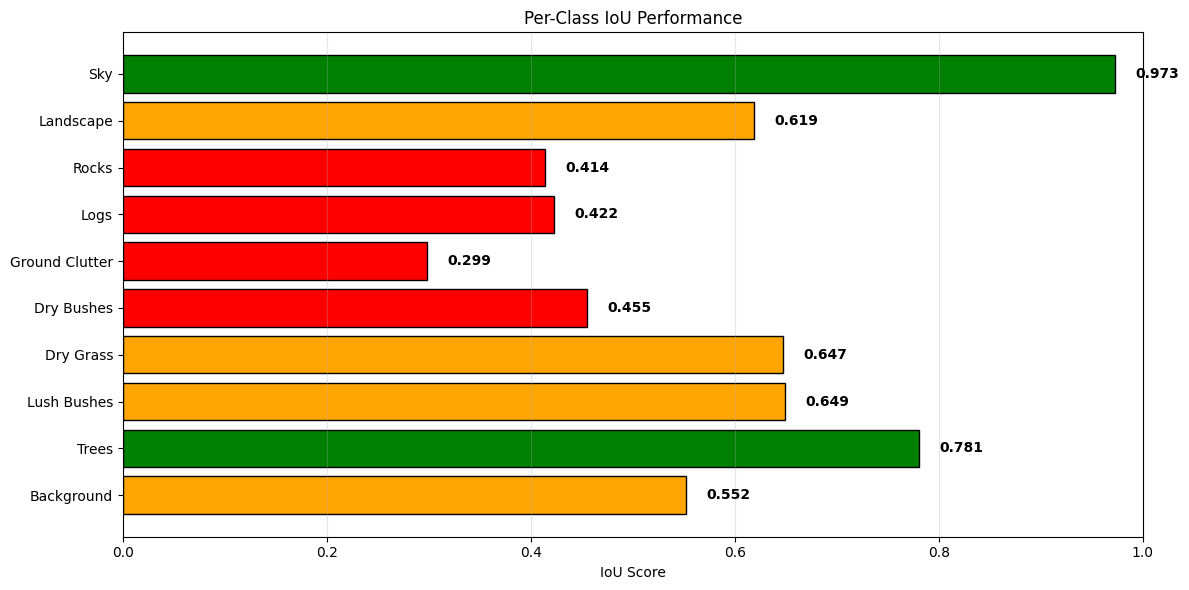


Mean IoU: 0.5810
✓ Per-class IoU plot saved!

✅ All visualizations complete!


In [42]:
# ============================================================================
# Run Complete Testing Pipeline
# ============================================================================

# Note: Only run this if you've already run cell 8 (Testing main function)
# This cell processes the results from testing

if 'predictions' in locals() and 'targets' in locals():
    # Generate visualizations if we have ground truth
    if predictions and targets:
        print("\n" + "="*50)
        print("GENERATING DETAILED ANALYSIS")
        print("="*50 + "\n")
        
        # Confusion Matrix
        print("Creating confusion matrix...")
        plot_confusion_matrix(predictions, targets, CLASS_NAMES)
        
        # Per-Class IoU
        print("\nCreating per-class IoU analysis...")
        plot_per_class_iou(predictions, targets, CLASS_NAMES)
        
        print("\n✅ All visualizations complete!")
    else:
        print("\nℹ️ No ground truth available - skipping detailed analysis.")
else:
    print("⚠️ Please run cell 8 (Testing) first to generate predictions and targets.")